In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import MarkerStyle as markerstyle
import math
from scipy.interpolate import griddata
import pandas
from scipy import constants
import matplotlib.patches as patches
import matplotlib.cm as cm

In [2]:
"""
------- Defining Constants ------------
"""
k = constants.value('Boltzmann constant')
Ava_no = constants.value('Avogadro constant')
temp = 310
kbt = (k*temp*Ava_no)

In [3]:
#Energies_File
ener_file = "../3D_Martini3/Energies_FINAL"
dist_file = "../3D_Martini3/Final_data_COMPLETE.txt"

ener_data = pandas.read_csv(ener_file,comment='#',sep='\t',dtype=np.float64)   #Reweighted Energy file
dist_data = pandas.read_csv(dist_file,comment='#',sep='\t',dtype=np.float64)   #Distance file


#Remove duplicates 
dist_data = dist_data.drop_duplicates(subset=['Timestep'],ignore_index=True)
ener_data = ener_data.drop_duplicates(subset=['Timestep'],ignore_index=True)

#Merge two dataframes
master_data3D = dist_data.join(ener_data.set_index('Timestep'),on='Timestep',how='inner',lsuffix = '_mda',rsuffix = '_plumed')

In [4]:
#Energies_File
ener_file = "../2D_Martini3/Filtered_Energies_195us.dat"
dist_file = "../2D_Martini3/Filtered_data_RMSD.dat"

ener_data = pandas.read_csv(ener_file,comment='#',sep='\t',dtype=np.float64)   #Reweighted Energy file
dist_data = pandas.read_csv(dist_file,comment='#',sep='\t',dtype=np.float64)   #Distance file


#Remove duplicates 
dist_data = dist_data.drop_duplicates(subset=['Timestep'],ignore_index=True)
ener_data = ener_data.drop_duplicates(subset=['Timestep'],ignore_index=True)

#Merge two dataframes
master_data2D = dist_data.join(ener_data.set_index('Timestep'),on='Timestep',how='inner',lsuffix = '_mda',rsuffix = '_plumed')

#Remove instances where protein came off membrane 
timesteps_array = master_data2D['Timestep']/1e6

#Timepoints to ignore 
 #33.0 - 66.0 us 
#95.2 - 97.8 us
#101.95 to 103.3 us 
#127.6 to 128.5 us

mask1 = (timesteps_array > 33.0) & (timesteps_array < 66.0)
mask2 = (timesteps_array > 95.2) & (timesteps_array < 97.8)
mask3 = (timesteps_array > 101.95) & (timesteps_array < 103.3)
mask4 = (timesteps_array > 127.6) & (timesteps_array < 128.5)
mask5 = (timesteps_array > 139) & (timesteps_array < 142.5)


mask = mask1 | mask2 | mask3 | mask4 | mask5

master_data2D = master_data2D[~mask]

In [5]:
#Energies_File
ener_file = "../Pseudo_Mem/Reweigthed_Data_FINAL"
dist_file = "../Pseudo_Mem/Final_data_102us.txt"

ener_data = pandas.read_csv(ener_file,comment='#',sep='\s+',dtype=np.float64)   #Reweighted Energy file
dist_data = pandas.read_csv(dist_file,comment='#',sep='\t',dtype=np.float64)   #Distance file
dist_data['Timestep'] = 200*round(dist_data['Timestep']/200)
#Remove duplicates 
dist_data = dist_data.drop_duplicates(subset=['Timestep'],ignore_index=True)
ener_data = ener_data.drop_duplicates(subset=['Timestep'],ignore_index=True)

# print("Energy Data: ", ener_data['Timestep'])

# print("Final_data: ", dist_data['Timestep'])

# # t_values = {'Timestep': dist_data['Timestep']}.values()
# mask1 = ener_data['Timestep'].isin(dist_data['Timestep'].values)
# print(mask1)
# ener_data = ener_data[~mask1]
# print(ener_data['Timestep'])



#Merge two dataframes
master_data_pseudo = dist_data.join(ener_data.set_index('Timestep'),on='Timestep',how='inner',lsuffix = '_mda',rsuffix = '_plumed')


### Plot RMSD vs FES

In [21]:

rw3D = np.exp(master_data3D['rbias']*1000/kbt)
rmsd_hist3D = np.histogram(master_data3D['RMSD-B'],bins=800,density=True,weights=rw3D)
rmsd_hist2D = np.histogram(master_data2D['RMSD-BtoA'],bins=800,density=True,weights=np.exp(master_data2D['rbias']*1000/kbt))
rmsd_hist_pseudo = np.histogram(master_data_pseudo['RMSD-B'],bins=800,density=True,weights=np.exp(master_data_pseudo['rbias']*1000/kbt))


def plot_fes(rmsd_hist,ax,prop={'color':'black','label':'3D'}):

    #Free Energy 
    free = -1*kbt*np.log(rmsd_hist[0]) /1000

    rmsd_list = rmsd_hist[1][:-1]
    free_list = free
    mask_rmsd = (rmsd_list>10) & (rmsd_list<12)
    zero_mark = np.mean(free_list[mask_rmsd])
    print(zero_mark)
    free_norm = free_list - zero_mark

    ax.plot(rmsd_list,free_norm,linewidth=2,color=prop['color'],label=prop['label'])
   


21.373185866546915
40.62768211057931
58.49794755884346


/tmp/ipykernel_43069/3570275503.py:10: RuntimeWarning: divide by zero encountered in log
  free = -1*kbt*np.log(rmsd_hist[0]) /1000


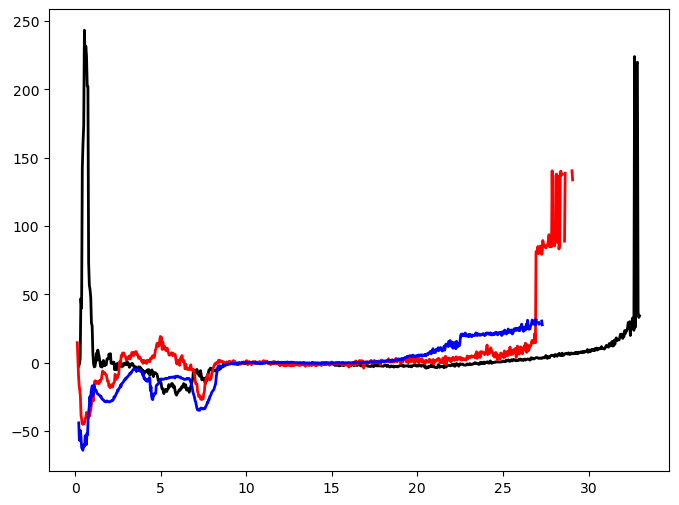

In [22]:
fig,ax=plt.subplots(figsize=(8,6))

plot_fes(rmsd_hist3D,ax,prop={'color':'black','label':'3D'})
plot_fes(rmsd_hist2D,ax,prop={'color':'red','label':'2D'})
plot_fes(rmsd_hist_pseudo,ax,prop={'color':'blue','label':'Pseudo'})
